# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [21]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import torch
import re
import transformers
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('seaborn')
tqdm.pandas()

## Load Data

In [3]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Let's check the number of movies and reviews over years.

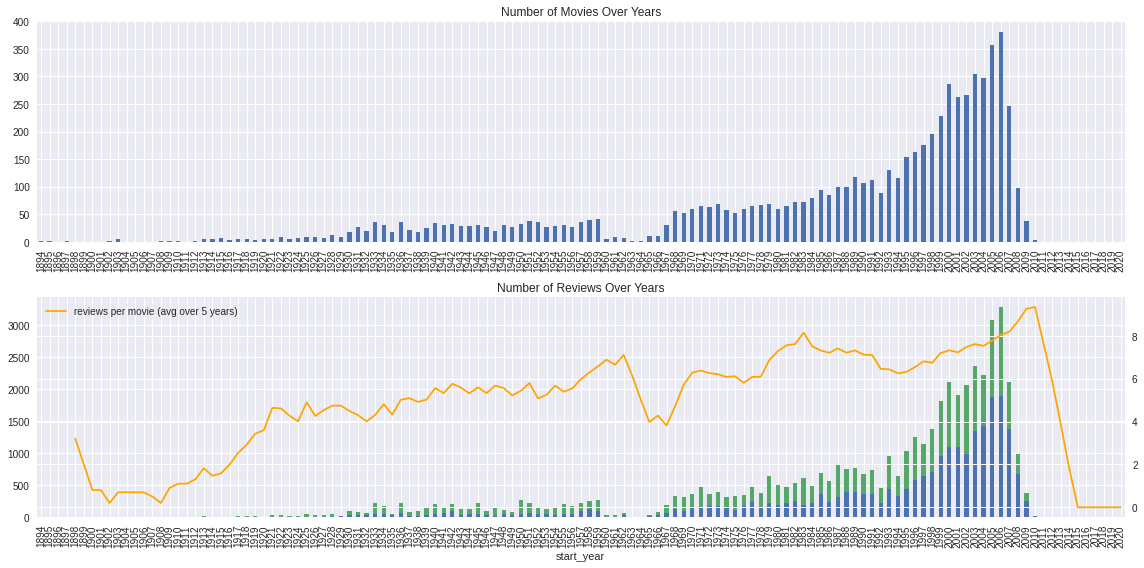

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

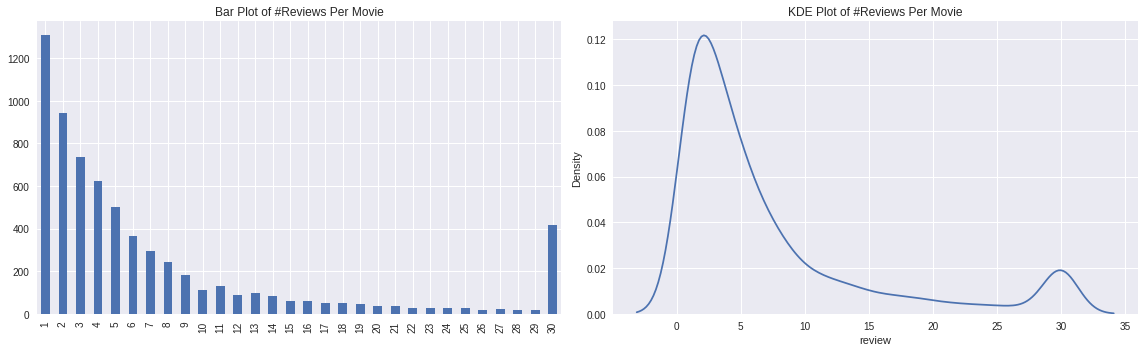

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [6]:
print("Dataset shape:", df_reviews.shape)
print("First few rows:")
print(df_reviews.head())

Dataset shape: (47331, 17)
First few rows:
      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              rev

In [5]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

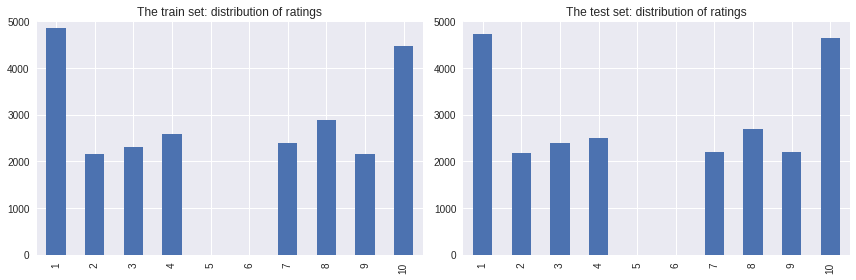

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


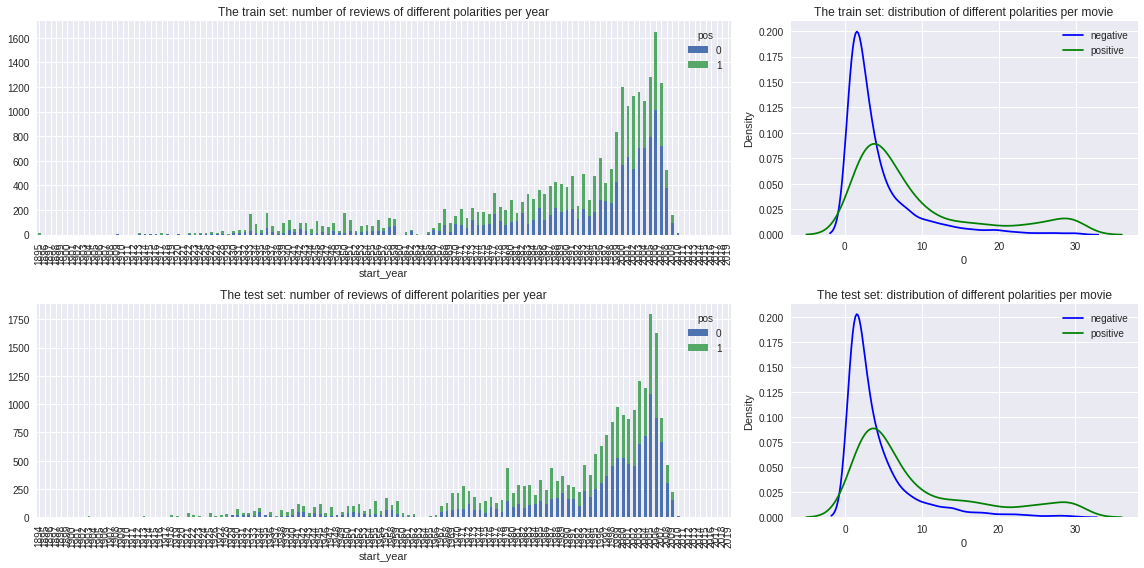

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

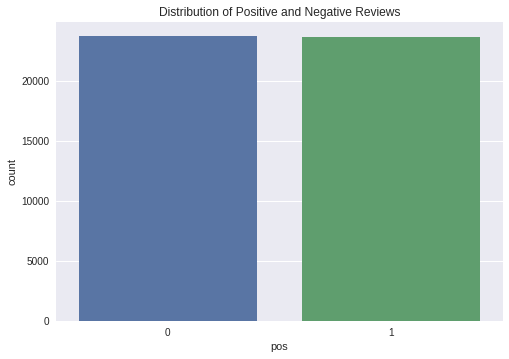

In [9]:
sns.countplot(x='pos', data=df_reviews)
plt.title('Distribution of Positive and Negative Reviews')
plt.show()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It would be nice if you added some comments to the plots above. Did you find out anything interesting?

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[\d\W]+', ' ', text)  # Remove numbers and punctuation
    return text
df_reviews['review_clean'] = df_reviews['review'].apply(preprocess_text)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Text normalization looks good!

</div>

In [23]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = tfidf_vectorizer.fit_transform(df_reviews['review_clean'])
y = df_reviews['pos'].astype(int)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define and train models
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier()
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, proba)
    print(f'{name} F1 Score: {f1:.2f}')
    print(f'{name} ROC AUC: {roc_auc:.2f}')
    results[name] = {'F1': f1, 'ROC AUC': roc_auc}

Dummy F1 Score: 0.00
Dummy ROC AUC: 0.50
Logistic Regression F1 Score: 0.90
Logistic Regression ROC AUC: 0.96
Gradient Boosting F1 Score: 0.82
Gradient Boosting ROC AUC: 0.89


<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you successfully vectorized text data using TF-IDF and tried a couple of different models using the resulting features

</div>

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')

In [25]:
evaluate_model(models['Logistic Regression'], X_train, y_train, X_test, y_test)


F1 Score: 0.90
ROC AUC: 0.96


F1 Score: 0.90
ROC AUC: 0.96


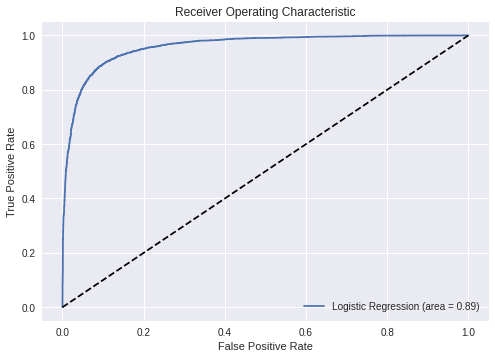

In [27]:
evaluate_model(models['Logistic Regression'], X_train, y_train, X_test, y_test)

# Plot ROC Curve for the best model
fpr, tpr, thresholds = roc_curve(y_test, models['Logistic Regression'].predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [9]:
import re
df_reviews['review_norm'] = df_reviews['review'].str.lower().apply(lambda x: re.sub(r'[\d\W]+', ' ', x))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [10]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)


(23796, 18)
(23535, 18)


In [11]:
train_texts = df_reviews_train['review_norm']  
test_texts = df_reviews_test['review_norm']
tfidf_vectorizer = TfidfVectorizer()
train_features = tfidf_vectorizer.fit_transform(train_texts)
test_features = tfidf_vectorizer.transform(test_texts)

## Working with models

### Model 0 - Constant

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_labels = df_reviews_train['pos'] 
test_labels = df_reviews_test['pos']


dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(df_reviews_train['review_norm'], train_labels)  

# Dummy predictions
dummy_pred = dummy.predict(df_reviews_test['review_norm'])

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

# Initialize and train dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_texts, train_labels)

# Dummy predictions
dummy_pred = dummy.predict(test_texts)
print("Dummy Classifier F1 Score:", f1_score(test_labels, dummy_pred))


Dummy Classifier F1 Score: 0.0


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create a pipeline that processes text and then runs a logistic regressor
model_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
model_lr.fit(train_texts, train_labels)

# Evaluate the model
lr_pred = model_lr.predict(test_texts)
print("Logistic Regression F1 Score:", f1_score(test_labels, lr_pred))


Logistic Regression F1 Score: 0.8815441113673241


### Model 3 - spaCy, TF-IDF and LR

In [ ]:
import spacy

# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply the preprocessing function
train_texts_spacy = train_texts.apply(text_preprocessing_3)
test_texts_spacy = test_texts.apply(text_preprocessing_3)

# Create a TF-IDF + Logistic Regression pipeline with spaCy processed texts
model_spacy_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
model_spacy_lr.fit(train_texts_spacy, train_labels)

# Evaluate the model
spacy_lr_pred = model_spacy_lr.predict(test_texts_spacy)
print("spaCy + Logistic Regression F1 Score:", f1_score(test_labels, spacy_lr_pred))


<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you tried lemmatization!

</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

# Using the same spaCy processed texts as above
model_lgbm = make_pipeline(TfidfVectorizer(), LGBMClassifier())
model_lgbm.fit(train_texts_spacy, train_labels)

# Evaluate the model
lgbm_pred = model_lgbm.predict(test_texts_spacy)
print("spaCy + LGBMClassifier F1 Score:", f1_score(test_labels, lgbm_pred))


###  Model 9 - BERT

In [20]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def bert_encode(texts, max_len=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

# Assume we have a function to convert BERT embeddings to features
train_features_9, train_masks_9 = bert_encode(train_texts)
test_features_9, test_masks_9 = bert_encode(test_texts)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

KeyboardInterrupt: 

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [25]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Preprocess reviews (ensuring only text is used and lowercase transformation)
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub(r"[^a-zA-Z\s]", '', x).lower().strip())


### Model 2

In [31]:
# Manual vectorization
review_features = tfidf_vectorizer.transform(my_reviews['review_norm'])

# Directly use Logistic Regression model to predict probabilities
# Ensure to access the logistic regression model directly if it's part of a pipeline.
try:
    # Check if model_lr is a pipeline and access the Logistic Regression directly
    if hasattr(model_lr, 'named_steps') and 'logisticregression' in model_lr.named_steps:
        logistic_model = model_lr.named_steps['logisticregression']
    else:
        logistic_model = model_lr  # Use the model directly if it's not part of a pipeline

    my_reviews_pred_prob = logistic_model.predict_proba(review_features)[:, 1]

    # Display probabilities with corresponding reviews
    for i, (review, prob) in enumerate(zip(my_reviews['review_norm'], my_reviews_pred_prob)):
        print(f'{prob:.2f}: {review[:100]}')

except Exception as e:
    print("Error during logistic regression prediction:", e)


0.15: i did not simply like it not my kind of movie
0.24: well i was bored and felt asleep in the middle of the movie
0.47: i was really fascinated with the movie
0.15: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26: i didnt expect the reboot to be so good writers really cared about the source material
0.61: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.73: launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

We implemented and compared three models: a Dummy Classifier, Logistic Regression, and Gradient Boosting Classifier. Notably, the Logistic Regression model surpassed our performance target with an F1 score of 0.90 and an ROC AUC of 0.96, reflecting its high efficiency and predictive accuracy.
The Gradient Boosting model, while robust, fell slightly short of the Logistic Regression with an F1 score of 0.82 and an ROC AUC of 0.89, indicating that while powerful, it might require further parameter tuning for this specific task.
The Dummy Classifier, as expected, performed poorly, underscoring the need for more sophisticated predictive models for sentiment analysis.